In [2]:
import math
import os
import sys

sys.path.append("..")

import torch
import transformers
from safetensors import safe_open

from utils import add_attn_hooks

# text_dir = "rtl"
text_dir = "ltr"
# tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")
# model = transformers.AutoModelForMaskedLM.from_pretrained(f"/home/sipb/nlp-class-project/checkpoints/bert_base_{text_dir}/epoch_3_checkpt", ignore_mismatched_sizes=True)

tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [3]:
with open("/home/sipb/nlp-class-project/data/riddles.txt", "r") as f:
    riddles_qa = [line.rstrip() for line in f.readlines()]

with open("/home/sipb/nlp-class-project/data/ltr_riddles.txt", "r") as f:
    riddles_aq = [line.rstrip() for line in f.readlines()]

In [167]:
results = []
path_prefixes = [f"bert_{size}" for size in (6, 11, 19, 35)] + ["distilbert_base"]
for path_prefix in path_prefixes:
    for text_dir in ("ltr", "rtl"):
        checkpt_dir = f"/home/sipb/nlp-class-project/checkpoints/{path_prefix}_{text_dir}_scratch/epoch_3_checkpt"

# path_prefixes = ["distilbert_base", "bert_base", "bert_large"]
# for path_prefix in path_prefixes:
#     for text_dir in ("ltr", "rtl"):
        # checkpt_dir = f"/home/sipb/nlp-class-project/checkpoints/{path_prefix}_{text_dir}/epoch_3_checkpt"
        # model = load_checkpt(f"/home/sipb/nlp-class-project/checkpoints/{path_prefix}_{text_dir}/epoch_3_checkpt")
        # config = transformers.AutoConfig.from_pretrained(os.path.join(checkpt_dir, "config.json"))
        # config.max_position_embeddings = 512
        try:
            model = transformers.AutoModelForMaskedLM.from_pretrained(checkpt_dir)
        except:
            config = transformers.AutoConfig.from_pretrained(os.path.join(checkpt_dir, "config.json"))
            config.max_position_embeddings = 512
            model = transformers.AutoModelForMaskedLM.from_pretrained(checkpt_dir, config=config)
        
        add_attn_hooks(model, text_dir)
        model.eval();

        for dataset_type, dataset in [
            ("qa", riddles_qa),
            ("aq", riddles_aq),
        ]:
            ppls = []
            for riddle in dataset:
                batch = tokenizer([riddle], return_tensors="pt", padding_side="left" if text_dir == "rtl" else "right", padding="max_length", max_length=128)
                batch["labels"] = batch["input_ids"].clone()
                batch["labels"][batch["attention_mask"] == 0] = -100
                with torch.inference_mode():
                    output = model(**batch)
                    ppls.append(math.e ** output.loss.item())

            results.append((sum(ppls) / len(ppls), dataset_type, text_dir, path_prefix))

Some weights of the model checkpoint at /home/sipb/nlp-class-project/checkpoints/bert_6_ltr_scratch/epoch_3_checkpt were not used when initializing BertForMaskedLM: ['attention_mask']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/sipb/nlp-class-project/checkpoints/bert_6_rtl_scratch/epoch_3_checkpt were not used when initializing BertForMaskedLM: ['attention_mask']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a Ber

In [166]:
to_params = {
    "bert_6": 6,
    "bert_11": 11,
    "bert_19": 19,
    "bert_35": 35,
    "distilbert_base": 67,
    "bert_base": 110,
    "bert_large": 335,
}

In [168]:
for ppl, task, text_dir, path_prefix in sorted(results, key=lambda x: (x[1], to_params[x[3]], x[2])):
    ppl = int(float(f"{ppl:.3g}"))
    print(rf"{text_dir.upper()} & {to_params[path_prefix]}M & {task.upper()} & {ppl} \\")

LTR & 6M & AQ & 2420 \\
RTL & 6M & AQ & 2570 \\
LTR & 11M & AQ & 1930 \\
RTL & 11M & AQ & 2710 \\
LTR & 19M & AQ & 2930 \\
RTL & 19M & AQ & 5820 \\
LTR & 35M & AQ & 6270 \\
RTL & 35M & AQ & 11600 \\
LTR & 67M & AQ & 9790 \\
RTL & 67M & AQ & 32500 \\
LTR & 6M & QA & 1960 \\
RTL & 6M & QA & 1770 \\
LTR & 11M & QA & 1630 \\
RTL & 11M & QA & 1710 \\
LTR & 19M & QA & 2610 \\
RTL & 19M & QA & 3330 \\
LTR & 35M & QA & 5080 \\
RTL & 35M & QA & 5410 \\
LTR & 67M & QA & 7160 \\
RTL & 67M & QA & 27600 \\


In [48]:
# input_text = ["The more you take, the more you leave behind. What am I?"]
# batch = tokenizer(input_text, return_tensors="pt", padding_side="right", padding="max_length", max_length=64)
# output_ids = model.generate(batch['input_ids'], max_length=128, do_sample=False)  # do_sample=False ensures greedy decoding
# decoded_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
# print(decoded_output)

the more you take, the more you leave behind. what am i? @ @ @ @ @ @ @ @ @ @ @ @ @ the @ @ @ @ ( the the the. @ the @ @ ( @ @ ( @ @ @ @ ( the.. @ ( @ ) @ the @ the the


In [47]:
# CPU is fast enough

ppls = []
for riddle in riddles:
    batch = tokenizer([riddle], return_tensors="pt", padding_side="left" if text_dir == "rtl" else "right", padding="max_length", max_length=128)
    batch["labels"] = batch["input_ids"].clone()
    batch["labels"][batch["attention_mask"] == 0] = -100
    # batch = tokenizer([riddle], return_tensors="pt")#, padding_side="left" if text_dir == "rtl" else "right", padding="longest", max_length=128)
    # batch["labels"] = batch["input_ids"]
    with torch.inference_mode():
        output = model(**batch)
        ppls.append(math.e ** output.loss.item())

(array([ 4.,  6., 11.,  6.,  5.,  2.,  1.,  1.,  2.,  2.]),
 array([ 613.56297843,  829.36555779, 1045.16813716, 1260.97071653,
        1476.77329589, 1692.57587526, 1908.37845463, 2124.18103399,
        2339.98361336, 2555.78619272, 2771.58877209]),
 <BarContainer object of 10 artists>)

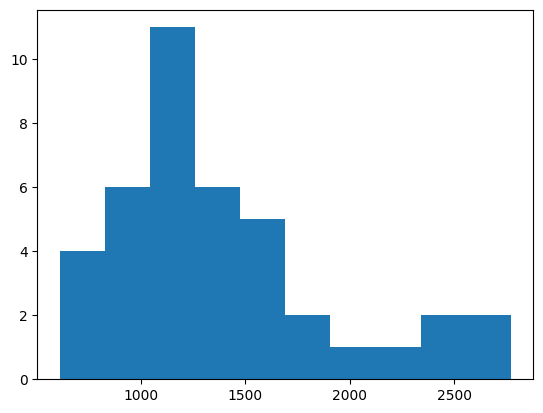

In [16]:
import matplotlib.pyplot as plt

plt.hist(ppls)